# Combination of fits of different models

In [5]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [6]:

""" 
IMPORTS
"""
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from scipy.stats import zscore


from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
# from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.hidden_markov_model import PoissonHMM

# Get my functionssessions_to_process
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from fitting_functions import compute_inputs

functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import best__kappa, best_lag_kappa, best_lag_kappa_bic, plot_grid_search
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
one = ONE(mode='remote')

## Parameters

In [7]:
# Parameters
bin_size = 0.017

""" FITTING PARAMETERS """
num_iters = 100
sticky = False
num_states = 2
num_train_batches = 5
method='prior'
fit_method='em'
zsc = False
truncate = True

if truncate:
    fitting_params = str(num_train_batches)+'_'+method+'_'+fit_method+'_zsc_'+str(zsc)+'_truncated/'
else:
    fitting_params = str(num_train_batches)+'_'+method+'_'+fit_method+'_zsc_'+str(zsc)+'/'  

save_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'+fitting_params

# Create folder where to dump data
if not os.path.exists(save_path):
    # Create a new directory because it does not exist
    os.makedirs(save_path)
        
# LOAD DATA
data_path =prefix + 'representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v6_21Jul2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

var_interest = ['avg_wheel_vel']
var_interest = ['l_paw_x', 'l_paw_y']
# var_interest = ['r_paw_x', 'r_paw_y']
var_interest = ['Lick count']
var_interest = ['whisker_me']


# Individual sessions

In [8]:
# Identify sessions availableto process
grid_search_path = prefix + 'representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/grid_search/individual_sessions/v6_21Jul2025/'+fitting_params
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    result_filename = os.path.join(grid_search_path, f"{'best_sticky' if sticky else 'best'}_results_{var_interest[0]}_{fit_id}")
    if os.path.exists(result_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 12 sessions to process.


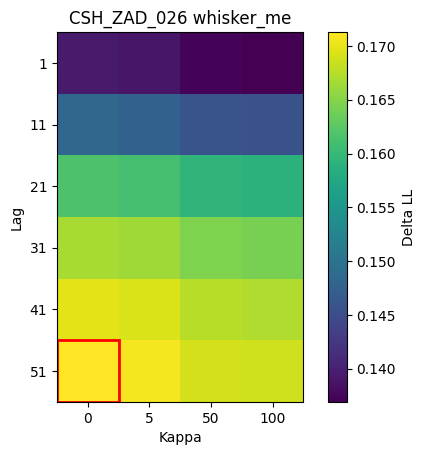

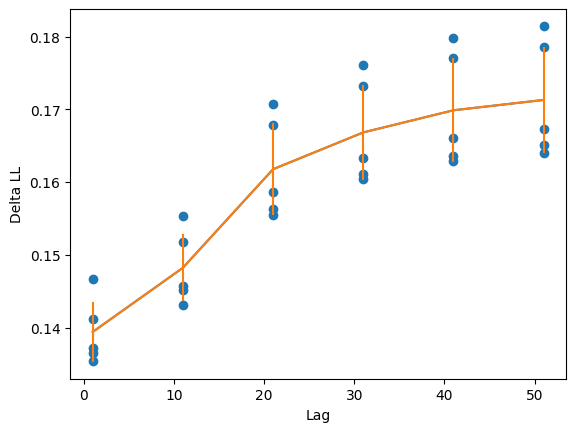

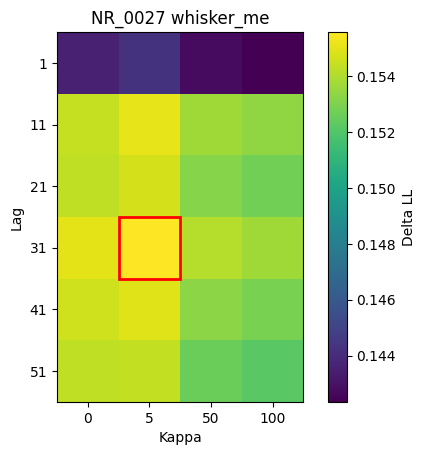

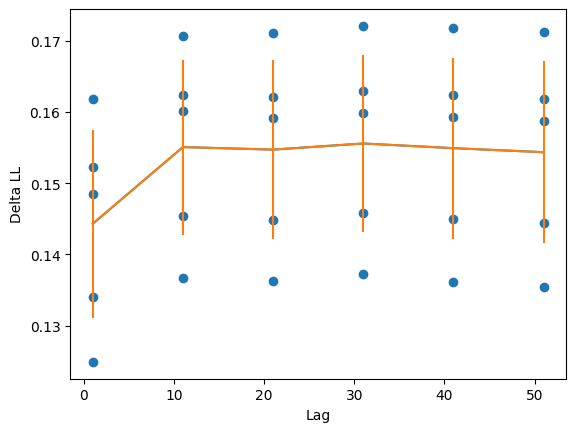

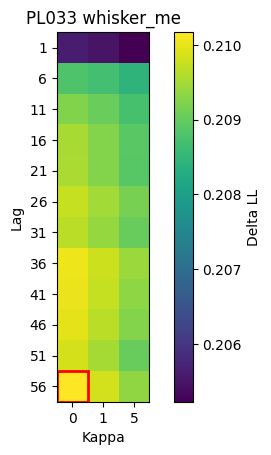

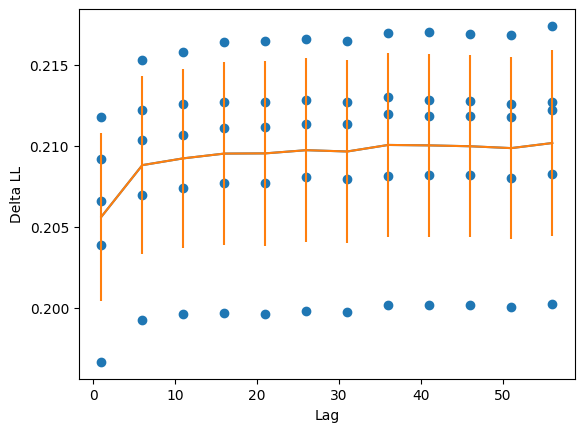

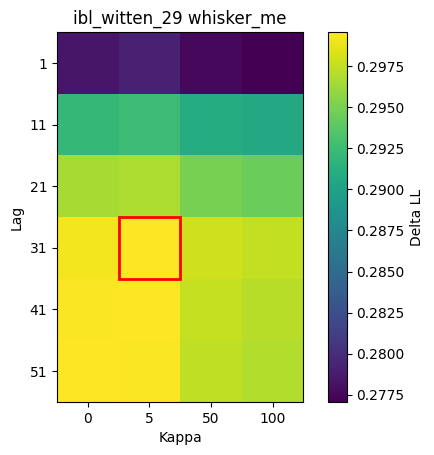

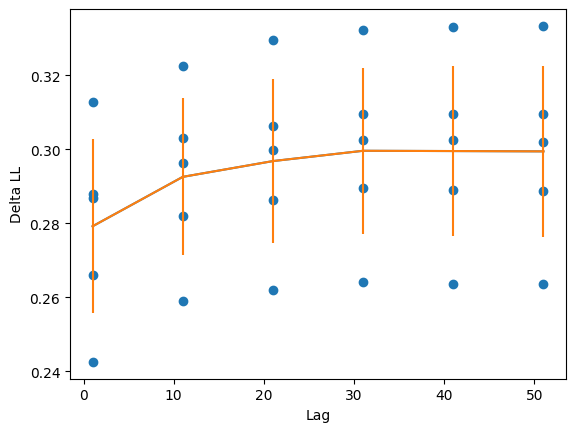

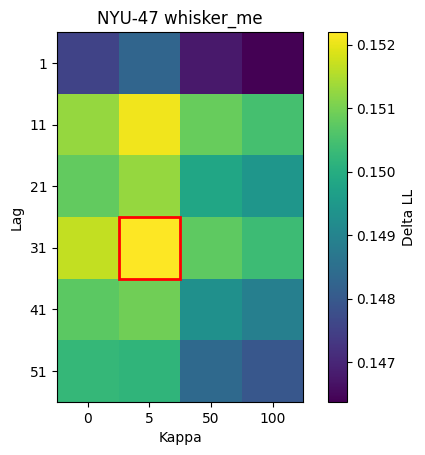

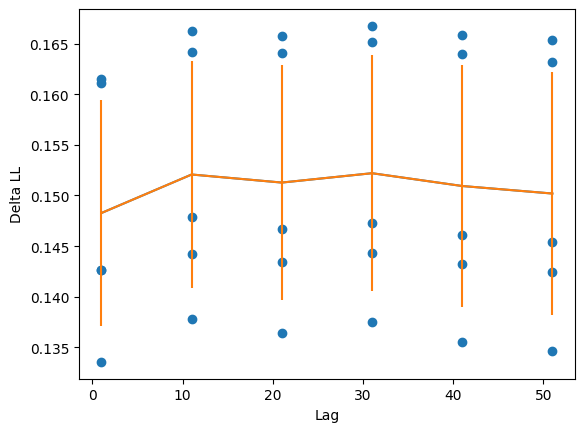

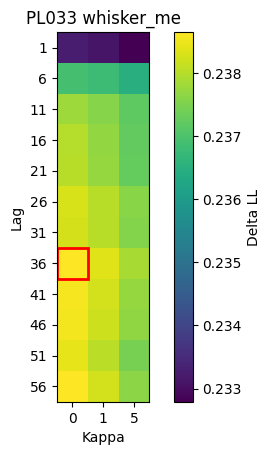

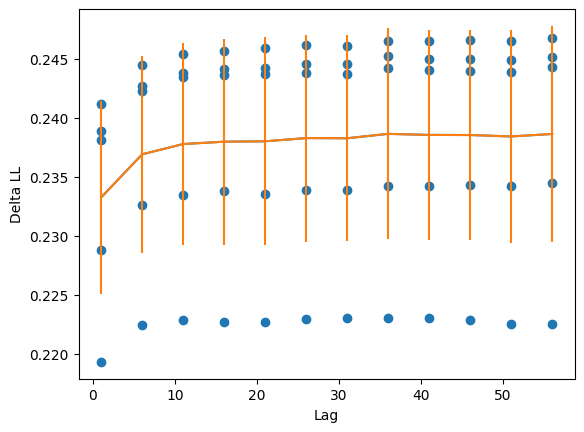

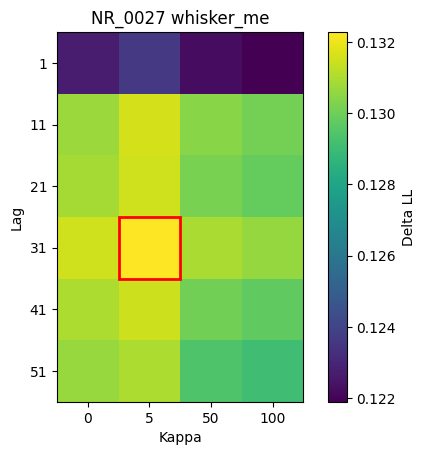

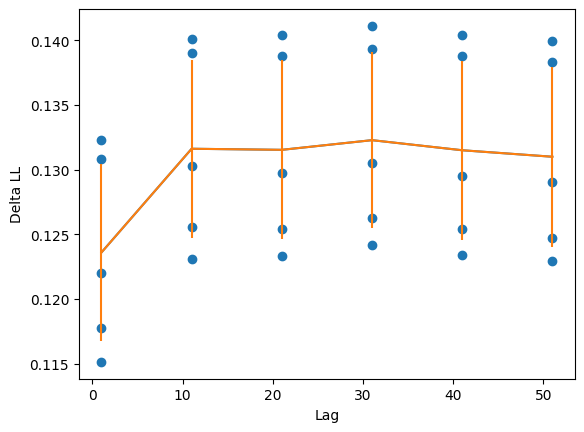

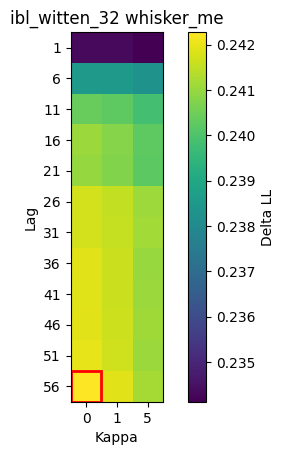

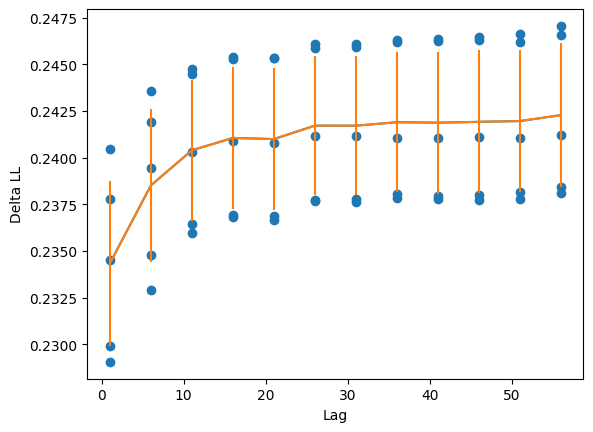

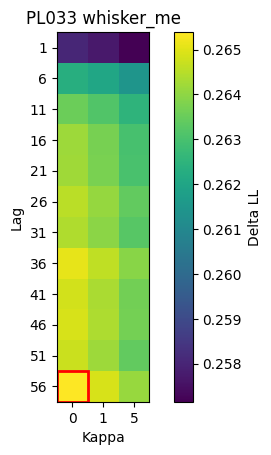

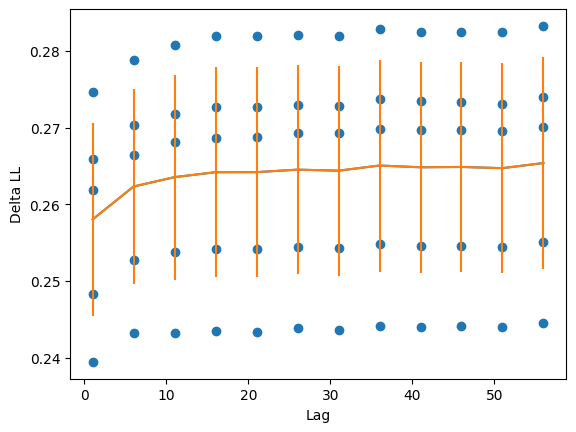

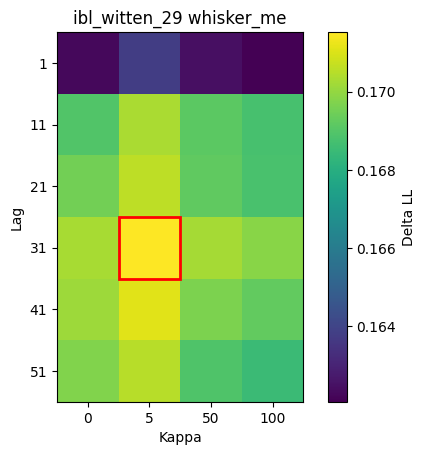

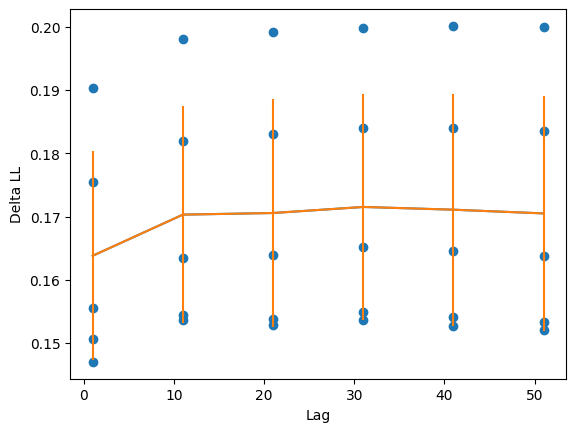

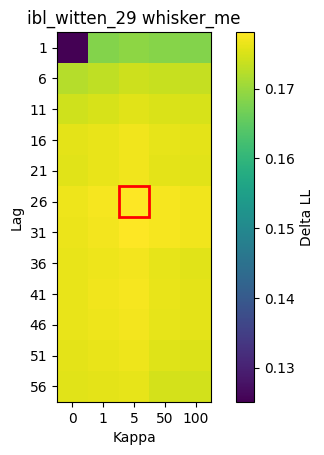

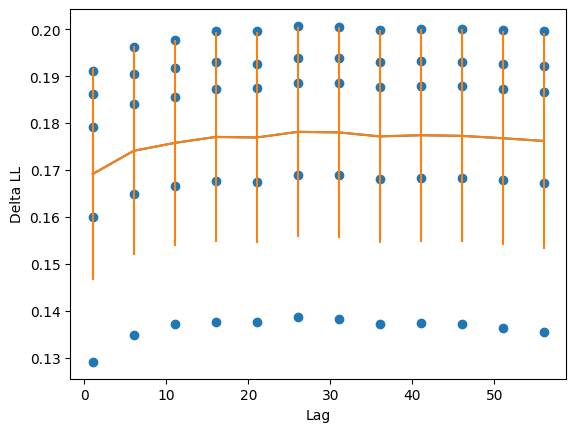

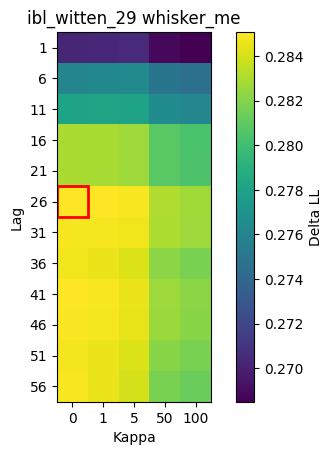

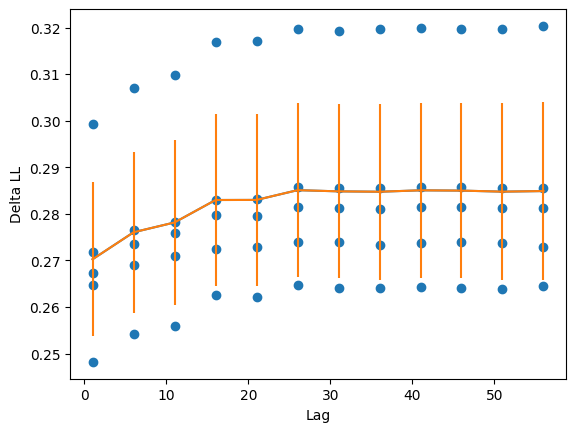

In [9]:
for m, mat in enumerate(sessions_to_process):
        
    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)

    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    original_design_matrix = pd.read_parquet(filename)

    # Zscore if needed (paws)
    if zsc == True:
        array_matrix = zscore(np.array(original_design_matrix), axis=0, nan_policy='omit')
    else:
        array_matrix = np.array(original_design_matrix)

    # Remove NaNs
    filtered_matrix = array_matrix[~np.isnan(array_matrix).any(axis=1)]
    keys = np.where(original_design_matrix.keys().isin(var_interest))
    design_matrix = filtered_matrix[:, keys]
    design_matrix = np.reshape(design_matrix,(np.shape(design_matrix)[0], np.shape(design_matrix)[2]))

    # Prepare data
    num_timesteps = np.shape(design_matrix)[0]
    emission_dim = np.shape(design_matrix)[1]
    shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
    train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))

    results_file = os.path.join(grid_search_path, 
                                f"{'best_sticky' if sticky else 'best'}_results_{var_interest[0]}_{fit_id}")
        
    # Retrieve best fits
    if 'Lick count' in var_interest:
        # Get results from grid search
        all_lls, all_baseline_lls, all_init_params, all_fit_params, _, params = pickle.load(open(results_file, "rb"))
        _, _, kappas = params
        best_kappa, mean_bits_LL, all_LL, mean_LL, best_fold = best__kappa(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas)
        index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
        use_fold = int(best_fold[index_kappa])

        " Fit model with best params"
        best_params = all_fit_params[best_kappa]
        best_parameters = num_states, np.nan, best_kappa
        # Find parameters for best fold
        initial_probs = best_params[0].probs[use_fold]
        transition_matrix = best_params[1].transition_matrix[use_fold]
        emission_rates = best_params[2].rates[use_fold]

        # Initialize new hmm
        test_phmm = PoissonHMM(num_states, emission_dim, transition_matrix_stickiness=best_kappa)
        best_fold_params, props = test_phmm.initialize(key=jr.PRNGKey(0), method=method,
                                        initial_probs=initial_probs,
                                        transition_matrix=transition_matrix,
                                        emission_rates=emission_rates)  # not sure if I need to includea
        # Get state estimates for validation data
        most_likely_states = test_phmm.most_likely_states(best_fold_params, shortened_array)

        # Plot grid search
        # plt.plot(mean_bits_LL)
        # plt.plot(mean_LL)
        plt.scatter([kappas]*num_train_batches, all_LL)
        plt.errorbar(kappas, np.nanmean(all_LL, axis=1), np.nanstd(all_LL, axis=1))
        plt.xlabel('Kappa')
        plt.xticks(np.arange(0, len(kappas), 1), kappas)
        plt.title(mouse_name + ' ' + var_interest[0])
        plt.show()
        print(best_kappa)
    else:
        # Get results from grid search
        all_lls, all_baseline_lls, all_init_params, all_fit_params, _, params = pickle.load(open(results_file, "rb"))
        _, Lags, kappas = params
        best_lag, best_kappa, mean_bits_LL, all_bits_LL, all_LL, mean_LL, best_fold = best_lag_kappa(all_lls, all_baseline_lls, 
                                                                                design_matrix, num_train_batches, 
                                                                                kappas, Lags, subtract_baseline=True)

        index_lag = np.where(np.array(Lags)==best_lag)[0][0]
        index_kappa = np.where(np.array(kappas)==best_kappa)[0][0]
        use_fold = int(best_fold[index_lag, index_kappa])
        
        best_parameters = num_states, best_lag, best_kappa
        
        # best_lag, best_kappa, mean_bits_LL, mean_LL, all_bic, best_fold = best_lag_kappa_bic(all_lls, all_baseline_lls, design_matrix, num_train_batches, kappas, Lags, num_states)
        
        " Fit model with best params"
        # Compute inputs for required timelags
        my_inputs = compute_inputs(shortened_array, best_lag, emission_dim)
        train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))

        best_params = all_fit_params[best_lag][best_kappa]

        # Find parameters for best fold
        initial_probs = best_params[0].probs[use_fold]
        transition_matrix = best_params[1].transition_matrix[use_fold]
        emission_weights = best_params[2].weights[use_fold]
        emission_biases = best_params[2].biases[use_fold]
        emission_covariances = best_params[2].covs[use_fold]

        # Initialize new hmm
        new_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=best_lag, transition_matrix_stickiness=best_kappa)
        best_fold_params, props = new_arhmm.initialize(key=jr.PRNGKey(0), method=method,
                                        initial_probs=initial_probs,
                                        transition_matrix=transition_matrix,
                                        emission_weights=emission_weights,
                                        emission_biases=emission_biases,
                                        emission_covariances=emission_covariances,
                                        emissions=shortened_array)  # not sure if I need to include

        # Get state estimates for validation data
        most_likely_states = new_arhmm.most_likely_states(best_fold_params, shortened_array, my_inputs)

        # Plot grid search
        plot_grid_search(best_kappa, best_lag, mean_bits_LL, kappas, Lags, mouse_name, var_interest[0])
        # plot_grid_search(best_kappa, best_lag, all_bic, kappas, Lags, mouse_name, var_interest[0])
        
        plt.scatter([Lags]*num_train_batches, all_bits_LL[:, index_kappa, :].T)
        plt.plot(Lags, np.nanmean(all_bits_LL[:, index_kappa, :], axis=1))
        plt.errorbar(Lags, np.nanmean(all_bits_LL[:, index_kappa, :], axis=1), np.nanstd(all_bits_LL[:, index_kappa, :], axis=1))
        plt.ylabel('Delta LL')
        plt.xlabel('Lag')
        plt.show()

    to_save = most_likely_states, use_fold, best_parameters

    # # Save most_likely_states
    # if sticky == True:
    #     states_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/sticky/'
    # else:I trained tens of mice using a very standardized training pipeline and became fascinated by how different mouse behavior can be (despite the experimental standardization). I have used data analyses techniques to characterize significant behavioral patterns in the dataset and identify mouse individuality traits (perhaps we can think of this as mouse 'personalities'). I attach my abstract to the CRS25 and am happy to give more details if pertinent
    #     states_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
    # pickle.dump(to_save, open(states_results_path + "most_likely_states" + var_names[0] + '_'+ fit_id , "wb"))

In [10]:
plt.errorbar([0, 1, 3, 5, 10, 100], np.mean(np.array(pd.DataFrame(all_baseline_lls)), axis=0), yerr=np.std(np.array(pd.DataFrame(all_baseline_lls)), axis=0))
# plt.errorbar([0, 1, 3, 5, 10, 100], np.std(np.array(pd.DataFrame(all_baseline_lls)), axis=0))
plt.ylabel('Log likelihood of baseline model')
# plt.scatter([0, 1, 3, 5, 10, 100], np.mean(np.array(pd.DataFrame(all_lls)), axis=0))
plt.xlabel('Kappa')
# plt.ylabel('Log likelihood of fit model')

TypeError: loop of ufunc does not support argument 0 of type jaxlib._jax.ArrayImpl which has no callable sqrt method